ΔI average value found via MCMC:0.007275046693386778+/-2.507807856595619e-10


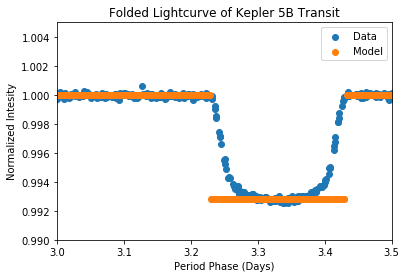

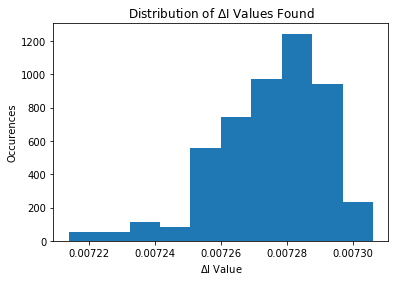

In [141]:
'''
ASTP-720, Fall 2020
Homework 7
Zach Diermyer
Problem 1 & Bonus
'''

import numpy as np
import matplotlib.pyplot as plt

def FindRadius(I, deltaI):
    '''
    Finds the radius of a transiting planet given the star's intensity and the change
    in intensity
    Inputs:
        I - Star intensity
        deltaI - Change in star's intensity
    Returns:
        Rp - Radius of the planet
    '''
    Rsun = 6.96e10  #Solar radius in cm
    Rstar = 1.79*Rsun
    squared = (deltaI/I)*Rstar**2
    Rp = (squared)**(1/2)
    return(Rp)

def ChiSquare(data, signal, error):
    '''
    Finds the chi-square value using input data and model values
    Inputs:
        data - Array of data intensity values
        signal - Array of model intensity values
        error - Array of data errors
    Returns:
        chi - Chi-square value
    '''
    if len(data) != len(signal):
        raise ValueError('Model and Data Arrays are not Equal Length')
    chi = 0
    for i in range(len(data)):
        chi += ((data[i] - signal[i])/error[i])**2
    return(chi/len(data))

def RMS(times, data, P, I, lim):
    '''
    Finds root mean square standard deviation of data to use for errors
    Inputs:
        times - Time values of data points
        data - Array of data intensity values
        P - Period of orbiting planet in days
        I - Intensity of star
        lim - Phase time limit to find RMS of data
    Returns:
        RMS/count - Standard deviation of data before phase limit
    '''
    RMS = 0
    count = 0
    for i in range(len(times)):
        if times[i] % P < lim:
            RMS += ((I - data[i])**2)**(1/2)
            count += 1
    return(RMS/count)

def CreateModel(times, P, w, tref, I, deltaI):
    '''
    Creates a boxcar intensity model for planetary transit using the input parameters
    Inputs:
        times - Time values to solve for model intensities
        P - Period of orbiting planet in days
        w - Width of drop in intensity; time planet is in front of star in days
        tref - Starting phase of planet passing in front of star
        I - Intensity of star
        deltaI - Drop in intensity due to planet passing in front of star
    Returns:
        model - Array of model values corresponding to each input time value
    '''
    enter = tref
    exit = tref + w
    model = []
    for i in range(len(times)):
        t = times[i] % P
        if t < enter:
            model.append(I)
        elif t > exit:
            model.append(I)
        else:
            model.append(I-deltaI)
    return(model)

def MetropolisHastings(times, data, error, P, guess, I, loop):
    w = [guess[0]]     #Initialize values with guesses
    tref = [guess[1]]
    deltaI = [guess[2]]
    while loop > 0:
        currw = w[-1]   #Reset/Set current best guesses
        currtref = tref[-1]
        currdeltaI = deltaI[-1]
        model = CreateModel(times = times, P = P, w = currw, tref = currtref, I = I, deltaI = currdeltaI)
        chi = ChiSquare(data = data, signal = model, error = error)
        L0 = np.exp(-(1/2)*chi)   #Likelihood of Xt
        sign = np.random.rand()   #Randomly step positively or negatively
        if sign >= 0.5:
            wguess = currw + 0.000001
            trefguess = currtref + 0.000001
            deltaIguess = currdeltaI + 0.000001
        else:
            wguess = currw - 0.000001
            trefguess = currtref - 0.000001
            deltaIguess = currdeltaI - 0.000001
        model1 = CreateModel(times = times, P = P, w = wguess, tref = currtref, I = I, deltaI = currdeltaI)
        chi1 = ChiSquare(data = data, signal = model1, error = error)
        L1 = np.exp(-(1/2)*chi1)   #First parameter likelihood
        r1 = L1/L0
        if r1 >= 1:    #Append new best value to parameter array
            w.append(wguess)
        else:
            U = np.random.uniform()
            if U <= r1:
                w.append(wguess)
        model2 = CreateModel(times = times, P = P, w = currw, tref = trefguess, I = I, deltaI = currdeltaI)
        chi2 = ChiSquare(data = data, signal = model2, error = error)
        L2 = np.exp(-(1/2)*chi2)   #Second parameter likelihood
        r2 = L2/L0
        if r2 >= 1:
            tref.append(trefguess)
        else:
            U = np.random.uniform()
            if U <= r2:
                tref.append(trefguess)
        model3 = CreateModel(times = times, P = P, w = currw, tref = currtref, I = I, deltaI = deltaIguess)
        chi3 = ChiSquare(data = data, signal = model3, error = error)
        L3 = np.exp(-(1/2)*chi3)   #Third parameter likelihood
        r3 = L3/L0
        if r3 >= 1:
            deltaI.append(deltaIguess)
        else:
            U = np.random.uniform()
            if U <= r3:
                deltaI.append(deltaIguess)
        loop -= 1
    return(w, tref, deltaI)

def main():
    data = open('lightcurve_data.txt', 'r')
    time = []
    phase = []
    flux = []
    P = 3.5485   #Period in days
    I = 1.0   #Normalized intensity
    while True:
        line = data.readline()
        if not line:
            break               #Exit if line is empty
        splitline = line.split()
        if splitline[0][0] == '#':
            pass
        else:
            time.append(float(splitline[0])-2400000.5)   #Convert from JD to MJD
            phase.append(time[-1] % P)
            flux.append(float(splitline[1]))
    sigma = RMS(times = time, data = flux, P = P, I = I, lim = 3.2)   #Calculate RMS variation of data
    error = []
    for i in range(len(flux)):
        error.append(sigma)
    plt.figure(1)
    plt.scatter(phase, flux)
    plt.ylim(0.990, 1.005)   #Zoom in on light curve
    plt.xlim(3.0, 3.5)
    labels = ('Data', 'Model')
    plt.title('Folded Lightcurve of Kepler 5B Transit')
    plt.ylabel('Normalized Intesity')
    plt.xlabel('Period Phase (Days)')
    guess = [0.2, 3.23, 0.00725]
    params = MetropolisHastings(times = time, data = flux, error = error, P = P, guess = guess, I = I, loop = 5000)
    model = CreateModel(times = time, P = P, w = params[0][-1], tref = params[1][-1], I = I, deltaI = params[2][-1])
    plt.scatter(phase, model)
    plt.legend(labels = labels)
    plt.figure(2)
    plt.hist(params[2])
    plt.title('Distribution of $\Delta$I Values Found')
    plt.ylabel('Occurences')
    plt.xlabel('$\Delta$I Value')
    print('\u0394I average value found via MCMC:' + str(np.average(params[2])) + '+/-' + str(np.var(params[2])))
main()